In [1]:
# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()

Cloning into 'notebooks'...
remote: Enumerating objects: 526, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 526 (delta 143), reused 135 (delta 126), pack-reused 354
Receiving objects: 100% (526/526), 28.62 MiB | 5.32 MiB/s, done.
Resolving deltas: 100% (250/250), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [2]:
# hide
from utils import *
setup_chapter()

Using transformers v4.16.2
Using datasets v1.16.1


# Dealing with Few to No Labels

<img alt="decision-tree" caption="Several techniques that can be used to improve model performance in the absence of large amounts of labeled data" src="images/chapter09_decision-tree.png" id="decision-tree"/>

## Building a GitHub Issues Tagger

<img alt="issue-example" caption="A typical GitHub issue on the Transformers repository" src="images/chapter09_issue-example-v2.png" id="issue-example"/>

### Getting the Data

#hide
### REPO ONLY: Code to Download Issues
If you want to download the issues yourself, you can query the Issues endpoint by using the _Requests_ library, which is the standard way for making HTTP requests in Python. Here is a function to fetch the issues from the Transformers repository:

In [3]:
#hide
import time
import math
import requests
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm

def fetch_issues(owner="huggingface", repo="transformers", num_issues=10_000,
                 rate_limit=5_000):
    batch = []
    all_issues = []
    per_page = 100 # Number of issues to return per page
    num_pages = math.ceil(num_issues / per_page)
    base_url = "https://api.github.com/repos"

    for page in tqdm(range(num_pages)):
        # Query with state=all to get both open and closed issues
        query = f"issues?page={page}&per_page={per_page}&state=all"
        issues = requests.get(f"{base_url}/{owner}/{repo}/{query}")
        batch.extend(issues.json())

        if len(batch) > rate_limit and len(all_issues) < num_issues:
            all_issues.extend(batch)
            batch = [] # Flush batch for next time period
            print(f"Reached GitHub rate limit. Sleeping for one hour ...")
            time.sleep(60 * 60 + 1)

    all_issues.extend(batch)
    df = pd.DataFrame.from_records(all_issues)
    df.to_json(f"github-issues-{repo}.jsonl", orient="records", lines=True)

#hide

Now when you call `fetch_issues()`, it will download all the issues in batches to avoid exceeding GitHub's limit on the number of requests per hour. The results will be stored in an _github-issues-transformers.jsonl_ file, where each line is a JSON object the represents the issue.

### Preparing the Data

In [4]:
import pandas as pd

dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)
print(f"DataFrame shape: {df_issues.shape}")

DataFrame shape: (9930, 26)


In [5]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [6]:
df_issues["labels"] = (df_issues["labels"]
                       .apply(lambda x: [meta["name"] for meta in x]))
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [7]:
df_issues["labels"].apply(lambda x : len(x)).value_counts().to_frame().T

,0,1,2,3,4,5
labels,6440,3057,305,100,25,3


In [8]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")
# Display the top-8 label categories
df_counts.to_frame().head(8).T

Number of labels: 65


,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
labels,2284,649,106,98,64,52,50,46


In [9]:
label_map = {"Core: Tokenization": "tokenization",
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage",
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch",
             "Examples": "examples",
             "Documentation": "documentation"}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

In [10]:
df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame().T

,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
labels,106,98,64,46,42,41,37,28,24


In [11]:
df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,split
unlabeled,9489
labeled,441


In [12]:
for column in ["title", "body", "labels"]:
    print(f"{column}: {df_issues[column].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o
tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the
title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural
modeling, yet nearly all commonly-used models still require an explicit
tokenization step. While recent tokenization approaches based on data-derived
subword lexicons are less brittle than manually en

labels: ['new model']



In [13]:
df_issues["text"] = (df_issues
                     .apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))

In [14]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"Removed {(len_before-len(df_issues))/len_before:.2%} duplicates.")

Removed 1.88% duplicates.


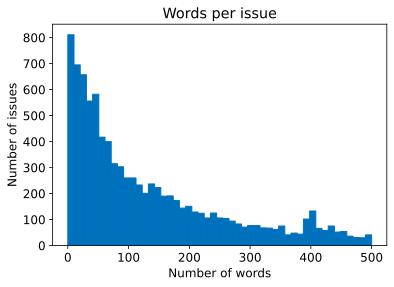

In [15]:
import numpy as np
import matplotlib.pyplot as plt

(df_issues["text"].str.split().apply(len)
 .hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0"))
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

### Creating Training Sets

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [17]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels,
                                                           test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

In [18]:
from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [19]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

### Creating Training Slices

In [20]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # Split off samples necessary to fill the gap to the next split size
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

# Add full dataset as last slice
train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [21]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])

Target split sizes:
[8, 16, 32, 64, 128, 223]
Actual split sizes:
[10, 19, 36, 68, 134, 223]


## Implementing a Naive Bayesline

In [22]:
#hide_output
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [23]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # Store metrics
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

In [25]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run,
                     linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run,
                     linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

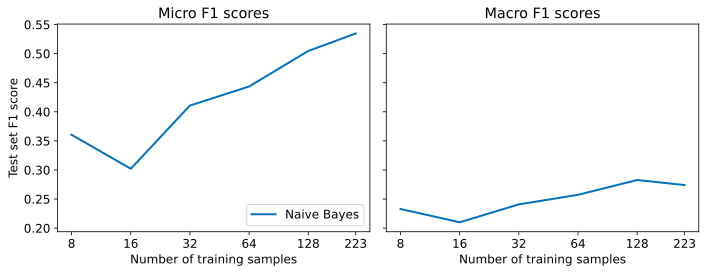

In [26]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

## Working with No Labeled Data

In [27]:
#hide_output
from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [28]:
movie_desc = "The main characters of the movie madacascar \
are a lion, a zebra, a giraffe, and a hippo. "
prompt = "The movie is about [MASK]."

output = pipe(movie_desc + prompt)
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:  0.103%
Token lions:    0.066%
Token birds:    0.025%
Token love:     0.015%
Token hunting:  0.013%


In [29]:
output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:  0.103%
Token cars:     0.001%


In [30]:
movie_desc = "In the movie transformers aliens \
can morph into a wide range of vehicles."

output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token cars:     0.139%
Token animals:  0.006%


In [31]:
from transformers import pipeline

pipe = pipeline("zero-shot-classification", device=0)

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [32]:
sample = ds["train"][0]
print(f"Labels: {sample['labels']}")
output = pipe(sample["text"], all_labels, multi_label=True)
print(output["sequence"][:400])
print("\nPredictions:")

for label, score in zip(output["labels"], output["scores"]):
    print(f"{label}, {score:.2f}")

Labels: ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o
tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the
title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural
modeling, yet nearly all commonly-used models still require an explicit tokeni

Predictions:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


In [33]:
# hide_output
def zero_shot_pipeline(example):
    output = pipe(example["text"], all_labels, multi_label=True)
    example["predicted_labels"] = output["labels"]
    example["scores"] = output["scores"]
    return example

ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

  0%|          | 0/106 [00:00<?, ?ex/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:976: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [34]:
def get_preds(example, threshold=None, topk=None):
    preds = []
    if threshold:
        for label, score in zip(example["predicted_labels"], example["scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example["predicted_labels"][i])
    else:
        raise ValueError("Set either `threshold` or `topk`.")
    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

In [35]:
def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])
    return classification_report(
        y_true, y_pred, target_names=mlb.classes_, zero_division=0,
        output_dict=True)

In [36]:
#hide_output
macros, micros = [], []
topks = [1, 2, 3, 4]
for topk in topks:
    ds_zero_shot = ds_zero_shot.map(get_preds, batched=False,
                                    fn_kwargs={'topk': topk})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report['micro avg']['f1-score'])
    macros.append(clf_report['macro avg']['f1-score'])

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

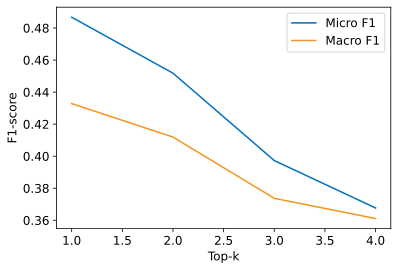

In [37]:
plt.plot(topks, micros, label='Micro F1')
plt.plot(topks, macros, label='Macro F1')
plt.xlabel("Top-k")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

In [38]:
#hide_output
macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    ds_zero_shot = ds_zero_shot.map(get_preds,
                                    fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

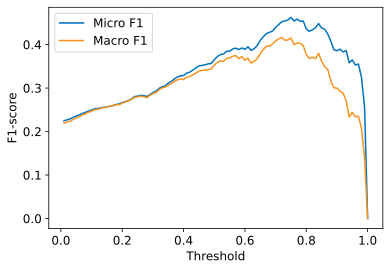

In [39]:
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

In [40]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (micro): {best_t} with F1-score {best_macro:.2f}.')

Best threshold (micro): 0.75 with F1-score 0.46.
Best threshold (micro): 0.72 with F1-score 0.42.


In [41]:
#hide_output
ds_zero_shot = ds['test'].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'topk': 1})
clf_report = get_clf_report(ds_zero_shot)
for train_slice in train_slices:
    macro_scores['Zero Shot'].append(clf_report['macro avg']['f1-score'])
    micro_scores['Zero Shot'].append(clf_report['micro avg']['f1-score'])

  0%|          | 0/111 [00:00<?, ?ex/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:976: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


  0%|          | 0/111 [00:00<?, ?ex/s]

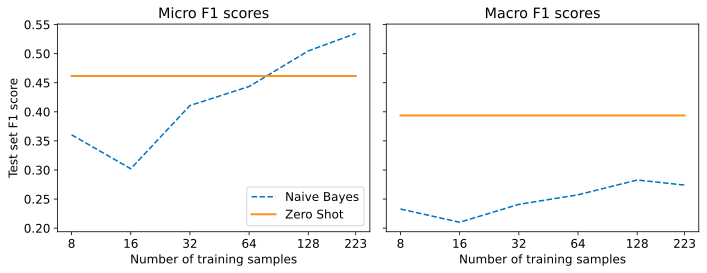

In [42]:
plot_metrics(micro_scores, macro_scores, train_samples, "Zero Shot")

## Working with a Few Labels

### Data Augmentation

In [44]:
#hide
from transformers import set_seed
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
import nltk

nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

set_seed(3)
text = "Even if you defeat me Megatron, others will rise to defeat your tyranny"
augs = {}
augs["synonym_replace"] = naw.SynonymAug(aug_src='wordnet')
augs["random_insert"] = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased",
                                device="cpu", action="insert", aug_max=1)
augs["random_swap"] = naw.RandomWordAug(action="swap")
augs["random_delete"] = naw.RandomWordAug()
augs["bt_en_de"] = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de',
    to_model_name='facebook/wmt19-de-en'
)
for k,v in augs.items():
    print(f"Original text: {text}")
    print(f"{k}: {v.augment(text)}")
    print("")

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original text: Even if you defeat me Megatron, others will rise to defeat your
tyranny
synonym_replace: Even if you kill me Megatron, others will prove to defeat your
tyranny

Original text: Even if you defeat me Megatron, others will rise to defeat your
tyranny
random_insert: even if you defeat me megatron, others humanity will rise to
defeat your tyranny

Original text: Even if you defeat me Megatron, others will rise to defeat your
tyranny
random_swap: You even if defeat me Megatron, others will rise defeat to tyranny
your

Original text: Even if you defeat me Megatron, others will rise to defeat your
tyranny
random_delete: Even if you me Megatron, others to defeat tyranny

Original text: Even if you defeat me Megatron, others will rise to defeat your
tyranny
bt_en_de: Even if you defeat me, others will rise up to defeat your tyranny



In [45]:
from transformers import set_seed
import nlpaug.augmenter.word as naw

set_seed(3)
aug = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased",
                                device="cpu", action="substitute")

text = "Transformers are the most popular toys"
print(f"Original text: {text}")
print(f"Augmented text: {aug.augment(text)}")

Original text: Transformers are the most popular toys
Augmented text: transformers'the most popular toys


In [46]:
def augment_text(batch, transformations_per_example=1):
    text_aug, label_ids = [], []
    for text, labels in zip(batch["text"], batch["label_ids"]):
        text_aug += [text]
        label_ids += [labels]
        for _ in range(transformations_per_example):
            text_aug += [aug.augment(text)]
            label_ids += [labels]
    return {"text": text_aug, "label_ids": label_ids}

In [47]:
#hide
for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    # Flatten augmentations and align labels!
    ds_train_aug = (ds_train_sample.map(
        augment_text, batched=True, remove_columns=ds_train_sample.column_names)
                    .shuffle(seed=42))
    y_train = np.array(ds_train_aug["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_aug["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # Store metrics
    macro_scores["Naive Bayes + Aug"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes + Aug"].append(clf_report["micro avg"]["f1-score"])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

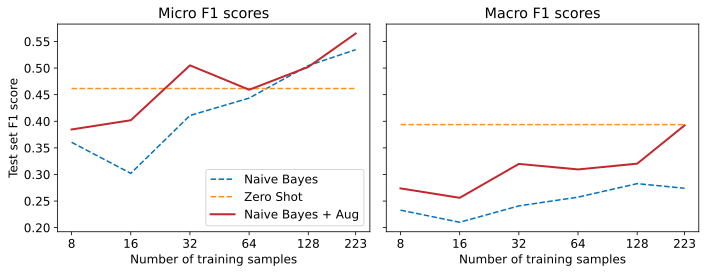

In [48]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes + Aug")

### Using Embeddings as a Lookup Table

<img alt="nearest-neighbours" caption="An illustration of nearest neighbor embedding lookup" src="images/chapter09_nearest-neighbours.png" id="nearest-neighbours"/>

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

def mean_pooling(model_output, attention_mask):
    # Extract the token embeddings
    token_embeddings = model_output[0]
    # Compute the attention mask
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float())
    # Sum the embeddings, but ignore masked tokens
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # Return the average as a single vector
    return sum_embeddings / sum_mask

def embed_text(examples):
    inputs = tokenizer(examples["text"], padding=True, truncation=True,
                       max_length=128, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

Downloading:   0%|          | 0.00/792 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.92G [00:00<?, ?B/s]

In [ ]:
# hide_output
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)

In [ ]:
# hide_output
embs_train.add_faiss_index("embedding")

In [ ]:
i, k = 0, 3 # Select the first query and 3 nearest neighbors
rn, nl = "\r\n\r\n", "\n" # Used to remove newlines in text for compact display

query =  np.array(embs_valid[i]["embedding"], dtype=np.float32)
scores, samples = embs_train.get_nearest_examples("embedding", query, k=k)

print(f"QUERY LABELS: {embs_valid[i]['labels']}")
print(f"QUERY TEXT:\n{embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n")
print("="*50)
print(f"Retrieved documents:")
for score, label, text in zip(scores, samples["labels"], samples["text"]):
    print("="*50)
    print(f"TEXT:\n{text[:200].replace(rn, nl)} [...]")
    print(f"SCORE: {score:.2f}")
    print(f"LABELS: {label}")

In [ ]:
def get_sample_preds(sample, m):
    return (np.sum(sample["label_ids"], axis=0) >= m).astype(int)

def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
    max_k = min(len(ds_train), max_k)
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k):
        for m in range(1, k + 1):
            _, samples = ds_train.get_nearest_examples_batch("embedding",
                                                             valid_queries, k=k)
            y_pred = np.array([get_sample_preds(s, m) for s in samples])
            clf_report = classification_report(valid_labels, y_pred,
                target_names=mlb.classes_, zero_division=0, output_dict=True)
            perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
            perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
    return perf_micro, perf_macro

In [ ]:
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0, ax1]:
    ax.set_xlim([0.5, 17 - 0.5])
    ax.set_ylim([17 - 0.5, 0.5])
    ax.set_xlabel("m")
plt.show()

In [ ]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f"Best k: {k}, best m: {m}")

In [ ]:
# hide_output
embs_train.drop_index("embedding")
test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embedding"], dtype=np.float32)

for train_slice in train_slices:
    # Create a FAISS index from training slice
    embs_train_tmp = embs_train.select(train_slice)
    embs_train_tmp.add_faiss_index("embedding")
    # Get best k, m values with validation set
    perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
    k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
    # Get predictions on test set
    _, samples = embs_train_tmp.get_nearest_examples_batch("embedding",
                                                           test_queries,
                                                           k=int(k))
    y_pred = np.array([get_sample_preds(s, m) for s in samples])
    # Evaluate predictions
    clf_report = classification_report(test_labels, y_pred,
        target_names=mlb.classes_, zero_division=0, output_dict=True,)
    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")

### Sidebar: Efficient Similarity Search with FAISS

<img alt="faiss-index" caption="The structure of a FAISS index: the gray points represent data points added to the index, the bold black points are the cluster centers found via k-means clustering, and the colored areas represent the regions belonging to a cluster center" src="images/chapter09_faiss-index.png" id="faiss-index"/>

### End sidebar

### Fine-Tuning a Vanilla Transformer

In [ ]:
#hide_output
import torch
from transformers import (AutoTokenizer, AutoConfig,
                          AutoModelForSequenceClassification)

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)
ds_enc = ds.map(tokenize, batched=True)
ds_enc = ds_enc.remove_columns(['labels', 'text'])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [ ]:
#hide_output
ds_enc.set_format("torch")
ds_enc = ds_enc.map(lambda x: {"label_ids_f": x["label_ids"].to(torch.float)},
                    remove_columns=["label_ids"])
ds_enc = ds_enc.rename_column("label_ids_f", "label_ids")

  0%|          | 0/223 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/111 [00:00<?, ?ex/s]

  0%|          | 0/9303 [00:00<?, ?ex/s]

In [ ]:
from transformers import Trainer, TrainingArguments

training_args_fine_tune = TrainingArguments(
    output_dir="./results", num_train_epochs=20, learning_rate=3e-5,
    lr_scheduler_type='constant', per_device_train_batch_size=4,
    per_device_eval_batch_size=32, weight_decay=0.0,
    evaluation_strategy="epoch", save_strategy="epoch",logging_strategy="epoch",
    load_best_model_at_end=True, metric_for_best_model='micro f1',
    save_total_limit=1, log_level='error')

In [ ]:
from scipy.special import expit as sigmoid

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred>0.5).astype(float)

    clf_dict = classification_report(y_true, y_pred, target_names=all_labels,
                                     zero_division=0, output_dict=True)
    return {"micro f1": clf_dict["micro avg"]["f1-score"],
            "macro f1": clf_dict["macro avg"]["f1-score"]}

In [ ]:
#hide_output
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

In [ ]:
# hide_output
for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model, tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],)

    trainer.train()
    pred = trainer.predict(ds_enc["test"])
    metrics = compute_metrics(pred)
    macro_scores["Fine-tune (vanilla)"].append(metrics["macro f1"])
    micro_scores["Fine-tune (vanilla)"].append(metrics["micro f1"])

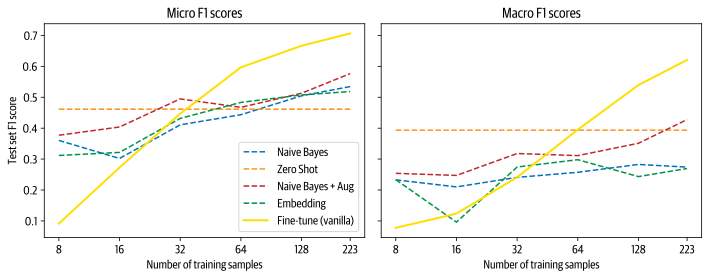

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (vanilla)")

### In-Context and Few-Shot Learning with Prompts

In [ ]:
prompt = """\
Translate English to French:
thanks =>
"""

## Leveraging Unlabeled Data

### Fine-Tuning a Language Model

In [ ]:
#hide_output
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True,
                     max_length=128, return_special_tokens_mask=True)

ds_mlm = ds.map(tokenize, batched=True)
ds_mlm = ds_mlm.remove_columns(["labels", "text", "label_ids"])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [ ]:
from transformers import DataCollatorForLanguageModeling, set_seed

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                                mlm_probability=0.15)

In [ ]:
set_seed(3)
data_collator.return_tensors = "np"
inputs = tokenizer("Transformers are awesome!", return_tensors="np")
outputs = data_collator([{"input_ids": inputs["input_ids"][0]}])

original_input_ids = inputs["input_ids"][0]
masked_input_ids = outputs["input_ids"][0]

pd.DataFrame({
    "Original tokens": tokenizer.convert_ids_to_tokens(original_input_ids),
    "Masked tokens": tokenizer.convert_ids_to_tokens(masked_input_ids),
    "Original input_ids": original_input_ids,
    "Masked input_ids": masked_input_ids,
    "Labels": outputs["labels"][0]}).T

,0,1,2,3,4,5
Original tokens,[CLS],transformers,are,awesome,!,[SEP]
Masked tokens,[CLS],transformers,are,awesome,[MASK],[SEP]
Original input_ids,101,19081,2024,12476,999,102
Masked input_ids,101,19081,2024,12476,103,102
Labels,-100,-100,-100,-100,999,-100


In [ ]:
data_collator.return_tensors = "pt"

In [ ]:
#hide_output
from transformers import AutoModelForMaskedLM

training_args = TrainingArguments(
    output_dir = f"{model_ckpt}-issues-128", per_device_train_batch_size=32,
    logging_strategy="epoch", evaluation_strategy="epoch", save_strategy="no",
    num_train_epochs=16, push_to_hub=True, log_level="error", report_to="none")

trainer = Trainer(
        model=AutoModelForMaskedLM.from_pretrained("bert-base-uncased"),
        tokenizer=tokenizer, args=training_args, data_collator=data_collator,
        train_dataset=ds_mlm["unsup"], eval_dataset=ds_mlm["train"])

trainer.train()

In [ ]:
# hide_output
trainer.push_to_hub("Training complete!")

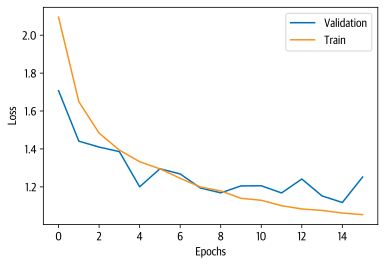

In [ ]:
df_log = pd.DataFrame(trainer.state.log_history)

(df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"]
 .plot(label="Validation"))
df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

### Fine-Tuning a Classifier

In [ ]:
#hide_output
model_ckpt = f'{model_ckpt}-issues-128'
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],
    )

    trainer.train()
    pred = trainer.predict(ds_enc['test'])
    metrics = compute_metrics(pred)
    # DA refers to domain adaptation
    macro_scores['Fine-tune (DA)'].append(metrics['macro f1'])
    micro_scores['Fine-tune (DA)'].append(metrics['micro f1'])

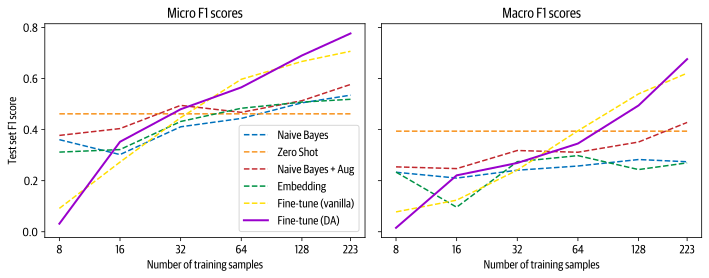

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (DA)")

### Advanced Methods

#### Unsupervised data augmentation

<img alt="uda" width="600" caption="Training a model M with UDA (courtesy of Qizhe Xie)" src="images/chapter09_uda.png" id="uda"/>    

#### Uncertainty-aware self-training

<img alt="ust" width="600" caption="The UST method consists of a teacher that generates pseudo-labels and a student that is subsequently trained on those labels; after the student is trained it becomes the teacher and the step is repeated (courtesy of Subhabrata Mukherjee)footnote:[S. Mukherjee and A.H. Awadallah, ["Uncertainty-Aware Self-Training for Few-Shot Text Classification"](https://arxiv.org/abs/2006.15315), (2020).]" src="images/chapter09_ust.png" id="ust"/>

## Conclusion